# Setup

In [ ]:
#!pip install --upgrade tensorflow
#!pip install scikeras
#!pip install keras
#!pip install tensorflow-determinism

# Libraries

In [ ]:
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import clear_output
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers, optimizers, callbacks
os.environ['TF_DETERMINISTIC_OPS'] = '1'
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

In [ ]:
# Replace these paths with the actual paths to your dataset folders
data_folder = "/content/drive/MyDrive/Deep_Learning_Fall23/Assignment/ISIC2018_Task3_Training_Input/"
ground_truth_folder = "/content/drive/MyDrive/Deep_Learning_Fall23/Assignment/ISIC2018_Task3_Training_GroundTruth/"

csv_file_path = os.path.join(ground_truth_folder, "ISIC2018_Task3_Training_GroundTruth.csv")
df = pd.read_csv(csv_file_path)

image_data = []
labels = []

for index, row in df.iterrows():
    image_title = row['image']
    label = row.drop('image', axis=0)  # Drop the 'image' column to keep only labels

    image_path = os.path.join(data_folder, image_title + ".jpg")

    try:
        # Open the image using PIL (or you can use OpenCV) within a 'with' statement
        with Image.open(image_path) as image:
            if image is not None:
                # Resize images
                im = image.resize((120,150), Image.LANCZOS)
                # Append image and label to respective lists
                image_data.append(np.array(im))
                labels.append(label)
            else:
                print(f"Error opening image '{image_path}': NoneType object returned")
    except Exception as e:
        print(f"Error opening image '{image_path}': {e}")

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("/content/drive/MyDrive/Deep_Learning_Fall23/Assignment/data.npy",image_matrix)
np.save("/content/drive/MyDrive/Deep_Learning_Fall23/Assignment/labels.npy",tr_labels)

# Class mapping
class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}

# Convert float labels to class names
class_labels = [class_mapping[tuple(label)] for label in tr_labels]
np.save("/content/drive/MyDrive/Deep_Learning_Fall23/Assignment/labels_name.npy",class_labels)

In [ ]:
drive.mount('/content/drive')
file_dir = "/content/drive/MyDrive/Deep_Learning_Fall23/Assignment/"
data = np.load(file_dir + "resized2_data.npy")
labels = np.load(file_dir + "labels.npy", allow_pickle=True)
class_labels = np.load(file_dir + "labels_name.npy")

# Data Partitioning

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

## Preprocessing

In [ ]:
# random seed for NumPy
np.random.seed(42)

# random seed for Python's built-in random module
random.seed(42)

# random seed for TensorFlow
tf.random.set_seed(42)

In [ ]:
# Data normalization
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')


# Visualizing Sample images

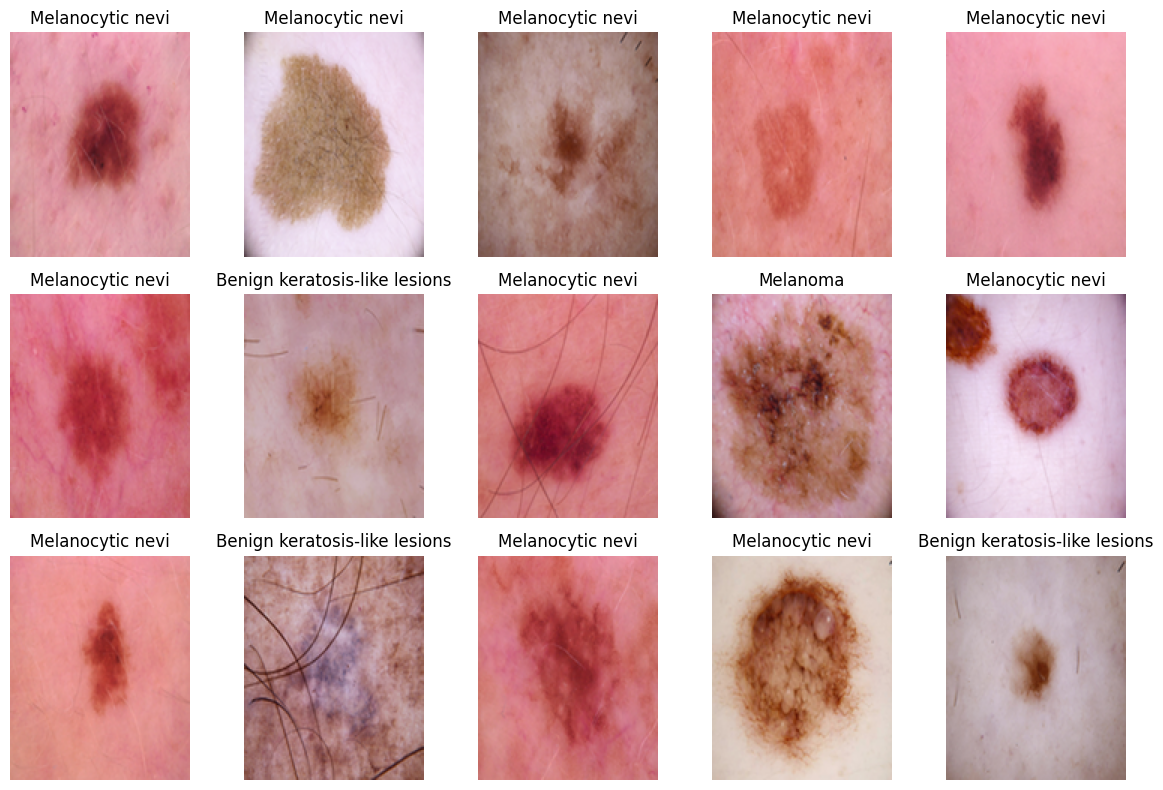

In [ ]:
#  3x5 graph displaying 15 random samples
plt.figure(figsize=(12, 8))
for i in range(15):
    idx = np.random.randint(len(data))

    image = data[idx]
    class_label = class_labels[idx]

    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.title(class_label)
    plt.axis('off')

plt.tight_layout()
plt.savefig('15sample.png',dpi=300)
plt.show()


# Visualize Class Label Distribution

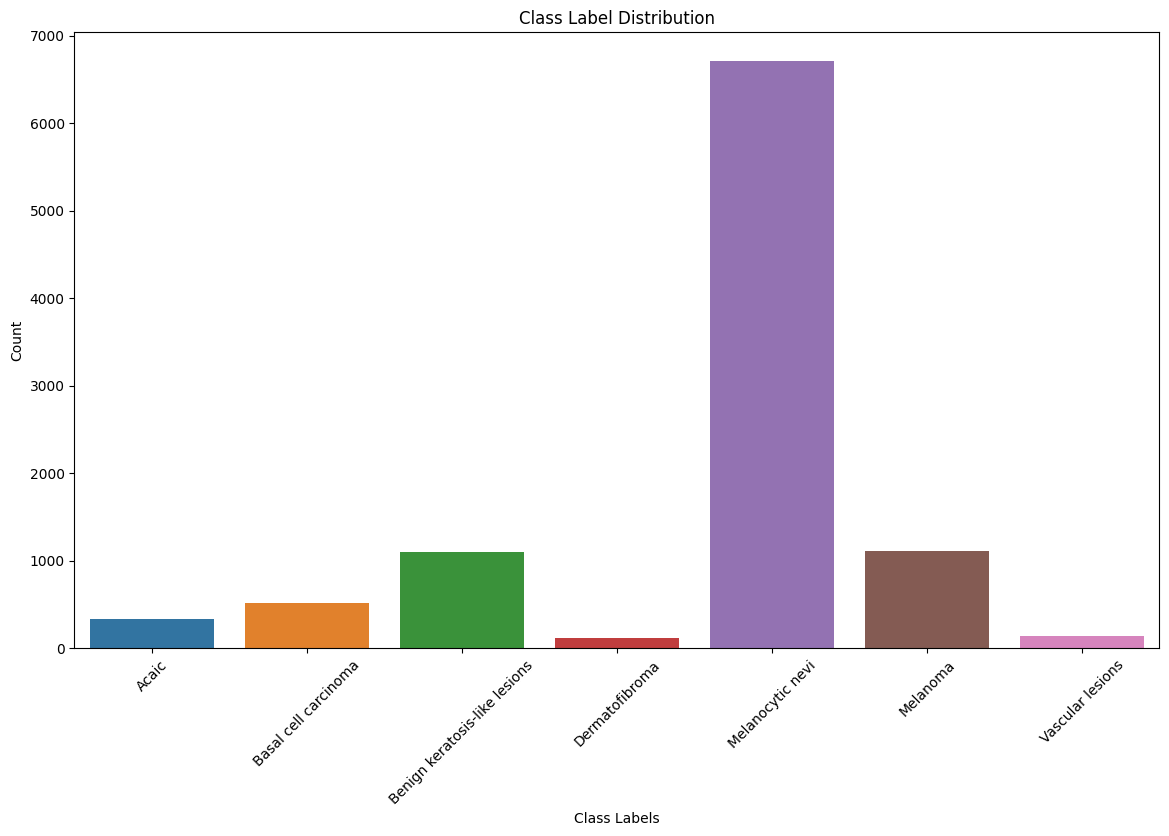

In [ ]:
class_labels_list = class_labels.tolist()

class_counts = {label: class_labels_list.count(label) for label in set(class_labels_list)}

sorted_class_counts = {label: count for label, count in sorted(class_counts.items())}

plt.figure(figsize=(14, 8))
sns.barplot(x=list(sorted_class_counts.keys()), y=list(sorted_class_counts.values()))
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Label Distribution')
plt.xticks(rotation=45)
plt.savefig('ClassDistribution.png')
plt.show()


# Baseline Model

In [ ]:
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 120, 3), padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))


# Flatten before densing
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Output Layer
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 120, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 120, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 30, 32)        0         
 g2D)                                                   

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# validation set predictions
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the validation set
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
val_classification_rep = classification_report(y_val_true_labels, y_val_pred_labels, zero_division=0)

# test set predictions
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the test set
test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
test_classification_rep = classification_report(y_test_true_labels, y_test_pred_labels, zero_division=0)

print("Validation Set:")
print(f'Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(val_classification_rep)

print("\nTest Set:")
print(f'Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(test_classification_rep)

Epoch 1/10
201/201 [==============================] - 31s 93ms/step - loss: 1.0305 - accuracy: 0.6695 - val_loss: 0.9721 - val_accuracy: 0.6694
Epoch 2/10
201/201 [==============================] - 17s 87ms/step - loss: 0.9237 - accuracy: 0.6684 - val_loss: 0.9718 - val_accuracy: 0.6700
Epoch 3/10
201/201 [==============================] - 17s 84ms/step - loss: 0.8999 - accuracy: 0.6753 - val_loss: 1.0119 - val_accuracy: 0.6719
Epoch 4/10
201/201 [==============================] - 17s 84ms/step - loss: 0.8607 - accuracy: 0.6826 - val_loss: 0.8830 - val_accuracy: 0.6800
Epoch 5/10
201/201 [==============================] - 18s 87ms/step - loss: 0.8429 - accuracy: 0.6865 - val_loss: 0.8231 - val_accuracy: 0.6931
Epoch 6/10
201/201 [==============================] - 17s 87ms/step - loss: 0.8096 - accuracy: 0.7018 - val_loss: 0.8695 - val_accuracy: 0.6737
Epoch 7/10
201/201 [==============================] - 18s 87ms/step - loss: 0.7779 - accuracy: 0.7210 - val_loss: 0.8360 - val_accuracy:

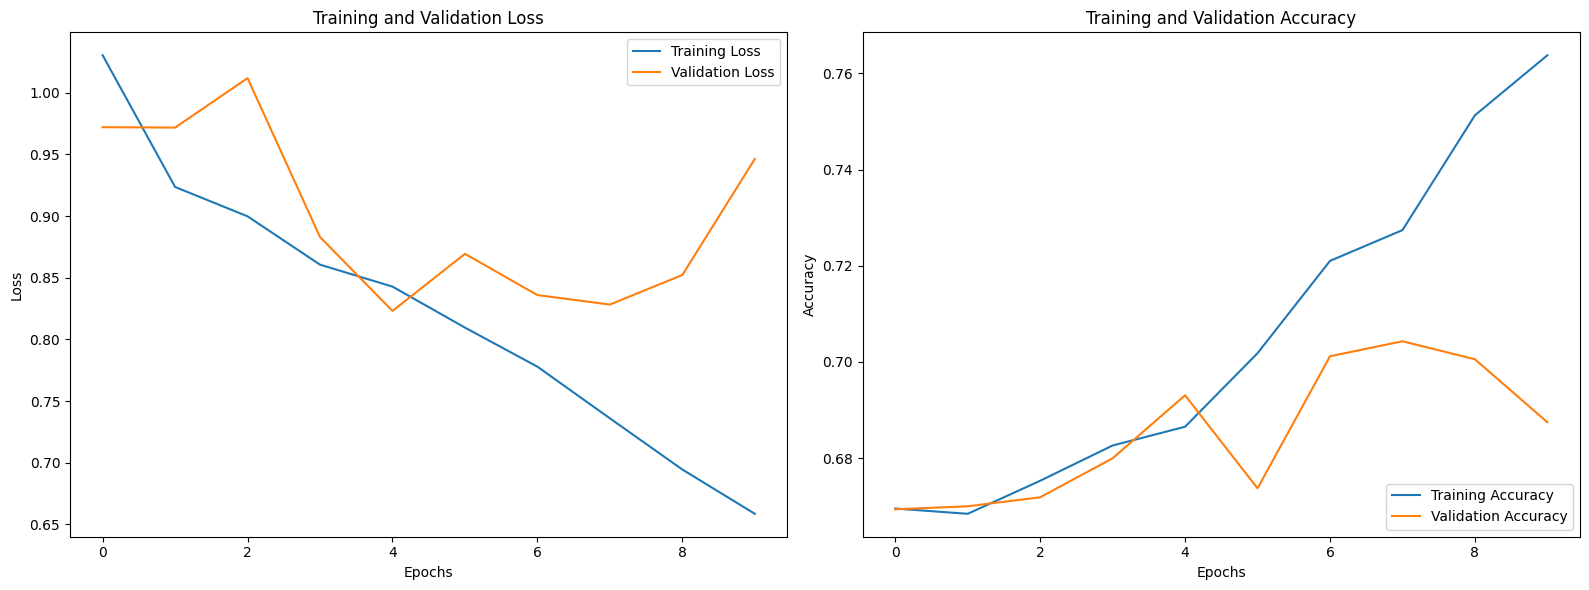

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

# training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='lower right')

plt.tight_layout()

plt.savefig('ModelLossAccuracyBaseline.png',dpi=300)

plt.show()


51/51 [==============================] - 1s 14ms/step


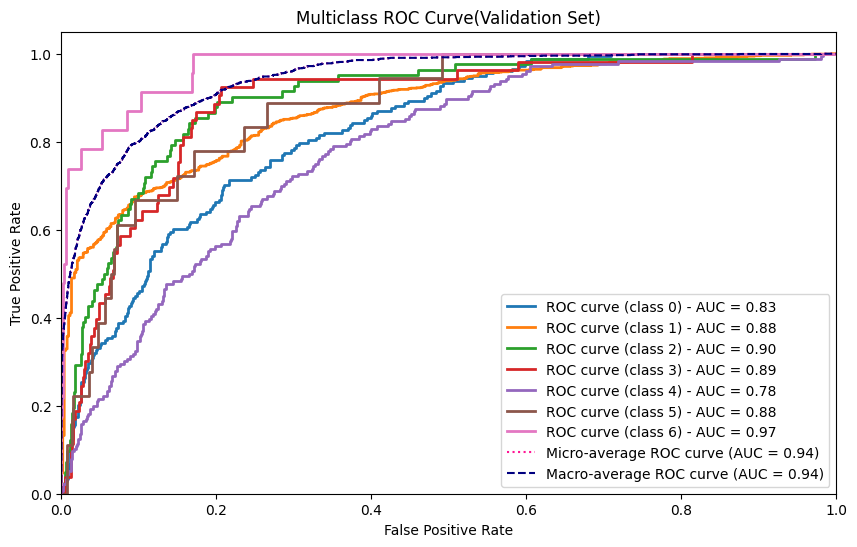

In [ ]:
y_val_pred = model.predict(X_val)
n_classes = len(np.unique(class_labels))  # Number of classes

# ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
roc_auc_macro = 0

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auc_macro += roc_auc[i]

# micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_val_pred.ravel())
roc_auc_micro = auc(fpr["micro"], tpr["micro"])

#  macro-average ROC AUC
roc_auc_macro /= n_classes

# ROC curves plot for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) - AUC = %0.2f' % (i, roc_auc[i]))

# micro-average plot ROC curve
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro, color='deeppink', linestyle=':')

# macro-average plot ROC curve
fpr_macro, tpr_macro, _ = roc_curve(y_val.ravel(), y_val_pred.ravel())
roc_auc_macro = auc(fpr_macro, tpr_macro)
plt.plot(fpr_macro, tpr_macro, label='Macro-average ROC curve (AUC = %0.2f)' % roc_auc_macro, color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve(Validation Set)')
plt.legend(loc='lower right')
plt.savefig('MultiRocValBaseline.png',dpi=300)
plt.show()


63/63 [==============================] - 1s 14ms/step


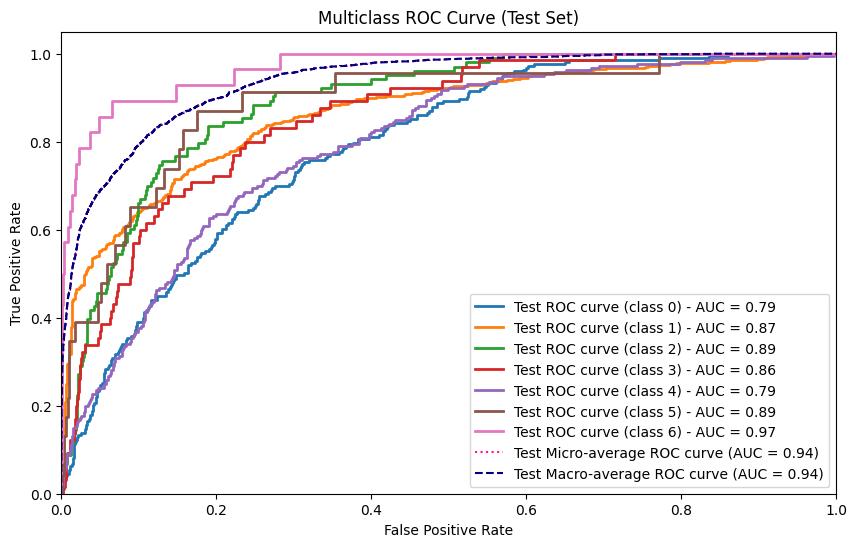

In [ ]:
# predictions on the test set
y_test_pred = model.predict(X_test)

n_classes = len(np.unique(class_labels))

# ROC curve and ROC AUC for each class in the test set
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
roc_auc_macro_test = 0

for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    roc_auc_macro_test += roc_auc_test[i]

# micro-average ROC curve and ROC AUC for the test set
fpr_test["micro"], tpr_test["micro"], _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc_micro_test = auc(fpr_test["micro"], tpr_test["micro"])

# macro-average ROC AUC for the test set
fpr_macro_test, tpr_macro_test, _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc_macro_test = auc(fpr_macro_test, tpr_macro_test)

# ROC curves plot for each class in the test set
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_test[i], tpr_test[i], lw=2, label='Test ROC curve (class %d) - AUC = %0.2f' % (i, roc_auc_test[i]))

# micro-average ROC curve plot for the test set
plt.plot(fpr_test["micro"], tpr_test["micro"], label='Test Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro_test, color='deeppink', linestyle=':')

# macro-average ROC curve plot for the test set
plt.plot(fpr_macro_test, tpr_macro_test, label='Test Macro-average ROC curve (AUC = %0.2f)' % roc_auc_macro_test, color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.savefig('MultiRocTestBaseline.png',dpi=300)
plt.show()


63/63 [==============================] - 1s 12ms/step


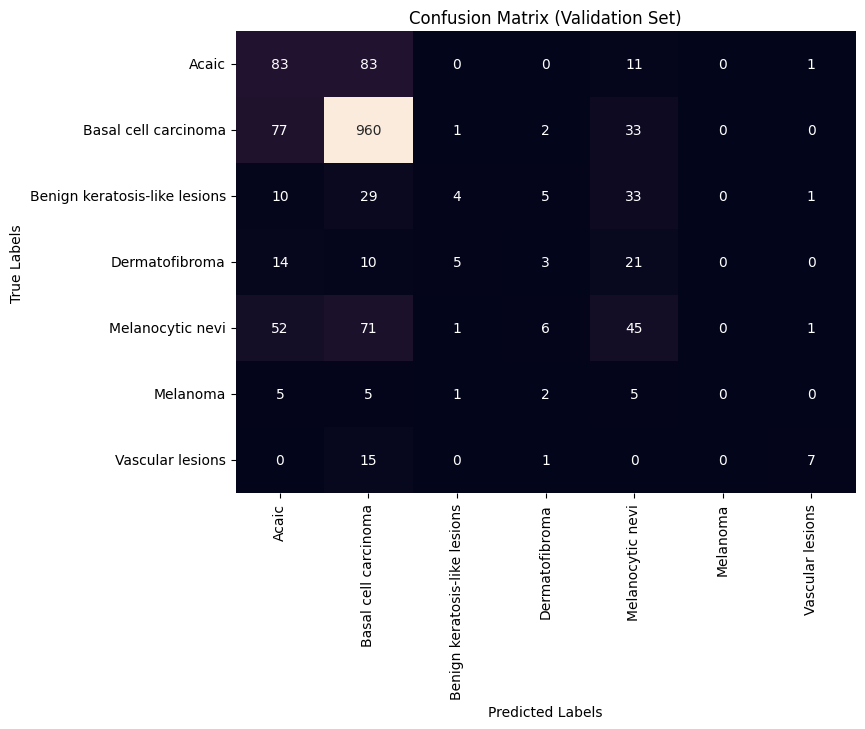

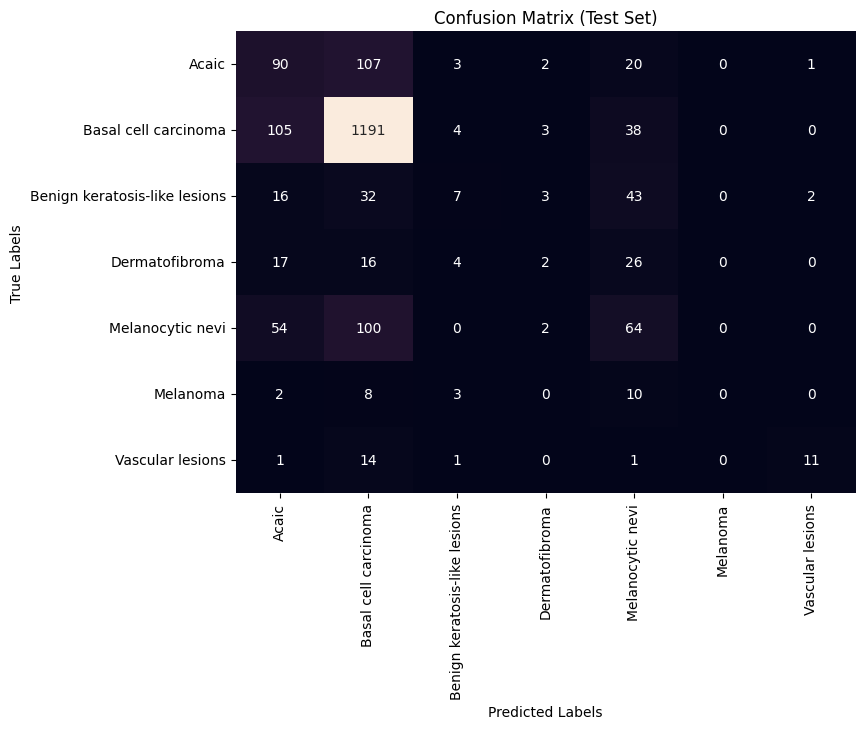

In [ ]:
# Predicting classes for the validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculating the true labels for the validation and test sets
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# confusion matrices
cm_val = confusion_matrix(y_val_true, np.argmax(y_val_pred, axis=1))
cm_test = confusion_matrix(y_test_true, np.argmax(y_test_pred, axis=1))

labels = np.unique(class_labels)

rocket_cmap = sns.color_palette("rocket", as_cmap=True)

# confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap=rocket_cmap, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=rocket_cmap, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Set)")
plt.savefig('MatrixBaseline.png',dpi=300)
plt.show()


## Enhanced Model

## Architecture

In [ ]:
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 120, 3), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten before dense layers
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# validation set predictions
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the validation set
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
val_classification_rep = classification_report(y_val_true_labels, y_val_pred_labels, zero_division=0)

# test set predictions
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the test set
test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
test_classification_rep = classification_report(y_test_true_labels, y_test_pred_labels, zero_division=0)

print("Validation Set:")
print(f'Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(val_classification_rep)

print("\nTest Set:")
print(f'Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(test_classification_rep)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 150, 120, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 60, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 60, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 37, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 37, 30, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 18, 15, 128)      

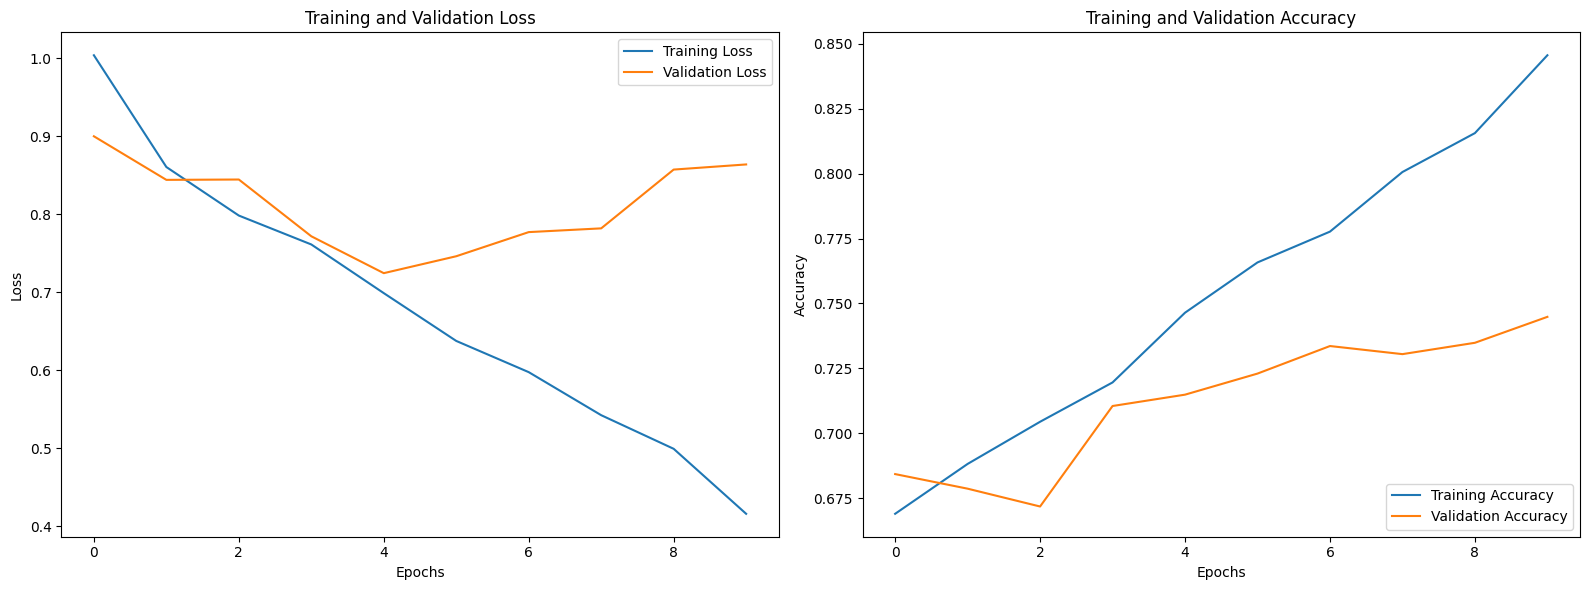

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

# Plot training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='lower right')

plt.tight_layout()

plt.savefig('ModelLossAccuracyEnchancedBasic.png',dpi=300)

plt.show()


## Dropout

In [ ]:
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 120, 3), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten before dense layers
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.7, seed=42))
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# more epochs and early stopping
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])


# validation set predictions
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the validation set
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
val_classification_rep = classification_report(y_val_true_labels, y_val_pred_labels, zero_division=0)

# test set predictions
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the test set
test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
test_classification_rep = classification_report(y_test_true_labels, y_test_pred_labels, zero_division=0)

print("Validation Set:")
print(f'Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(val_classification_rep)

print("\nTest Set:")
print(f'Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(test_classification_rep)

Epoch 1/40
201/201 [==============================] - 19s 38ms/step - loss: 1.0849 - accuracy: 0.6656 - val_loss: 1.0947 - val_accuracy: 0.6694
Epoch 2/40
201/201 [==============================] - 5s 26ms/step - loss: 0.9783 - accuracy: 0.6694 - val_loss: 0.9163 - val_accuracy: 0.6681
Epoch 3/40
201/201 [==============================] - 5s 27ms/step - loss: 0.9282 - accuracy: 0.6697 - val_loss: 0.8785 - val_accuracy: 0.6687
Epoch 4/40
201/201 [==============================] - 6s 28ms/step - loss: 0.8962 - accuracy: 0.6736 - val_loss: 0.9177 - val_accuracy: 0.6762
Epoch 5/40
201/201 [==============================] - 5s 27ms/step - loss: 0.8654 - accuracy: 0.6783 - val_loss: 0.7888 - val_accuracy: 0.6931
Epoch 6/40
201/201 [==============================] - 5s 27ms/step - loss: 0.8233 - accuracy: 0.6881 - val_loss: 0.8506 - val_accuracy: 0.7031
Epoch 7/40
201/201 [==============================] - 5s 26ms/step - loss: 0.8294 - accuracy: 0.6959 - val_loss: 0.7797 - val_accuracy: 0.703

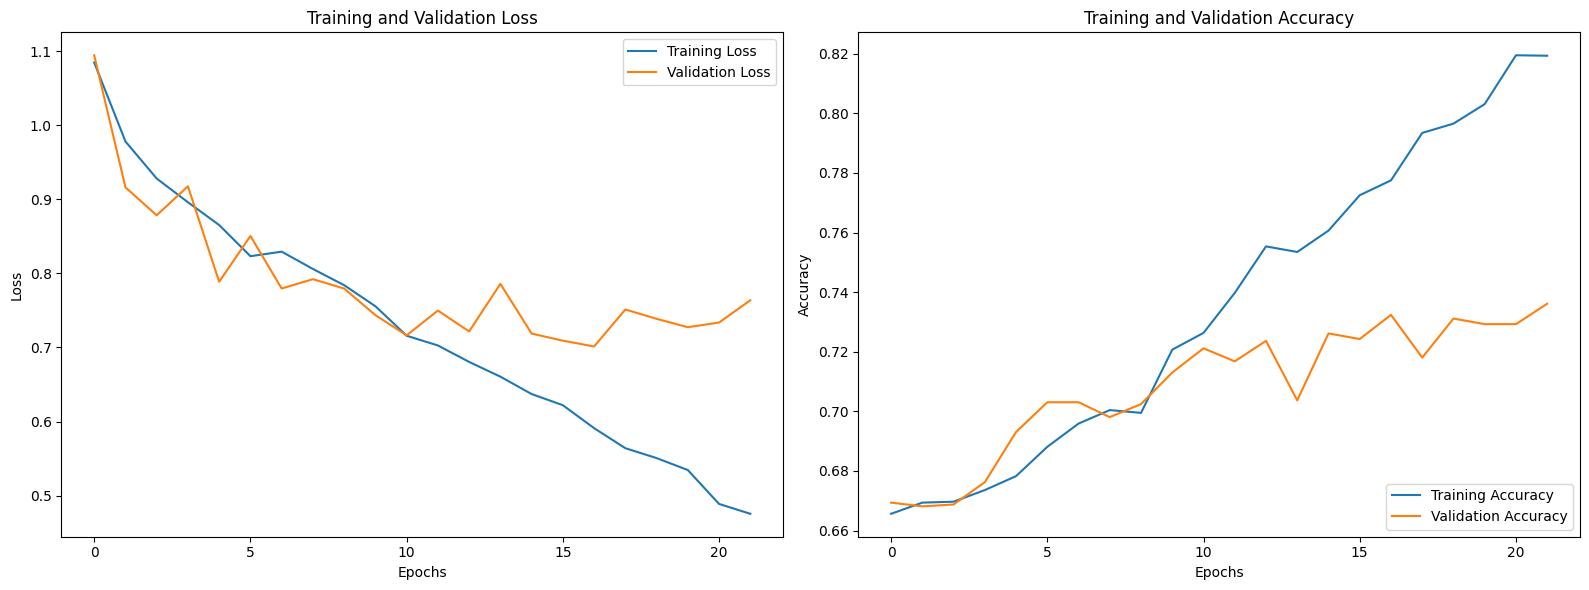

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

# training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='lower right')

plt.tight_layout()

plt.savefig('ModelLossAccuracyEnchancedDropout.png',dpi=300)

plt.show()


## Dropout, learning rate

In [ ]:
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 120, 3), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten before dense layers
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.7, seed=42))
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(7, activation='softmax'))

custom_optimizer = optimizers.Adam(learning_rate=0.001)

# learning rate scheduler
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)

model.compile(optimizer=custom_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

# validation set predictions
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the validation set
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
val_classification_rep = classification_report(y_val_true_labels, y_val_pred_labels, zero_division=0)

# test set predictions
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the test set
test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
test_classification_rep = classification_report(y_test_true_labels, y_test_pred_labels, zero_division=0)

print("Validation Set:")
print(f'Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(val_classification_rep)

print("\nTest Set:")
print(f'Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(test_classification_rep)

Epoch 1/40
201/201 [==============================] - 18s 33ms/step - loss: 1.0849 - accuracy: 0.6656 - val_loss: 1.0947 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 2/40
201/201 [==============================] - 6s 27ms/step - loss: 0.9733 - accuracy: 0.6686 - val_loss: 0.9102 - val_accuracy: 0.6694 - lr: 9.0000e-04
Epoch 3/40
201/201 [==============================] - 5s 26ms/step - loss: 0.9146 - accuracy: 0.6695 - val_loss: 0.8666 - val_accuracy: 0.6750 - lr: 8.1000e-04
Epoch 4/40
201/201 [==============================] - 5s 26ms/step - loss: 0.8746 - accuracy: 0.6748 - val_loss: 0.8486 - val_accuracy: 0.6719 - lr: 7.2900e-04
Epoch 5/40
201/201 [==============================] - 6s 27ms/step - loss: 0.8577 - accuracy: 0.6820 - val_loss: 0.8092 - val_accuracy: 0.6987 - lr: 6.5610e-04
Epoch 6/40
201/201 [==============================] - 5s 25ms/step - loss: 0.8320 - accuracy: 0.6872 - val_loss: 0.8666 - val_accuracy: 0.6931 - lr: 5.9049e-04
Epoch 7/40
201/201 [=======================

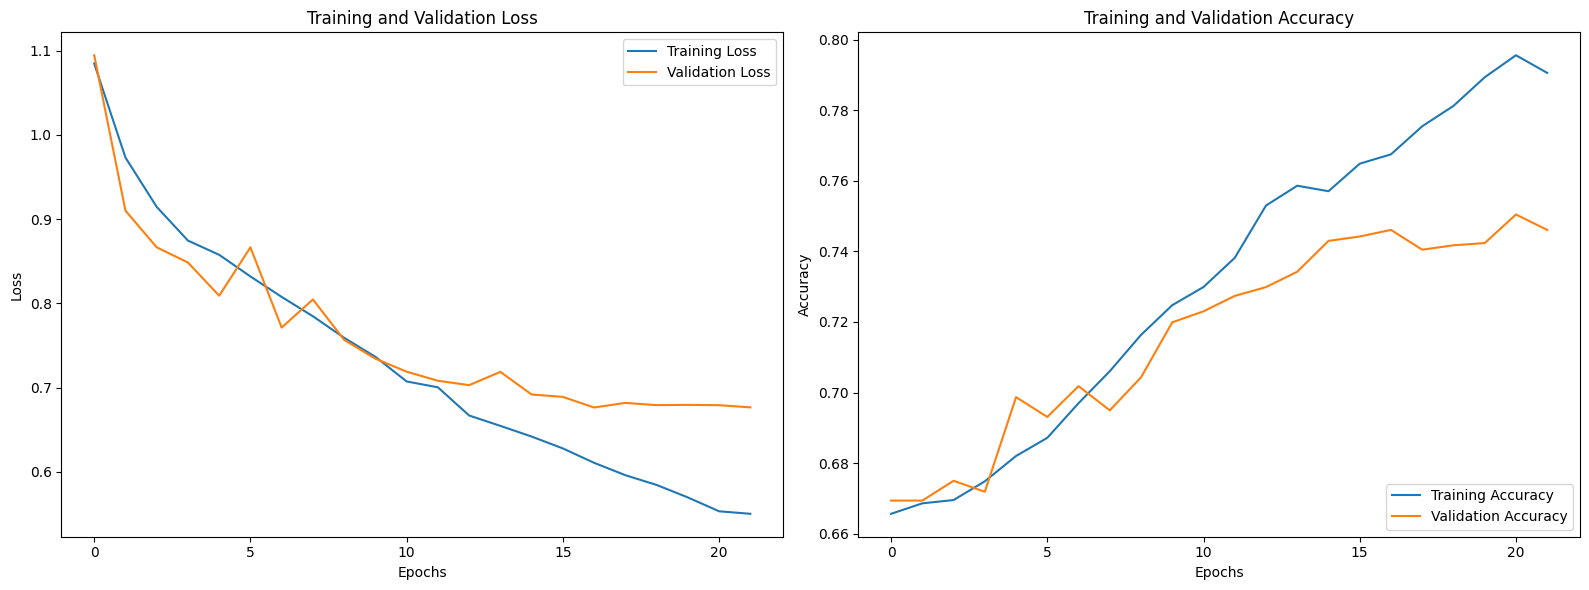

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

# training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='lower right')

plt.tight_layout()

plt.savefig('ModelLossAccuracyDropoutLearningRate.png',dpi=300)

plt.show()


### Data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

# validation set predictions
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the validation set
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
val_classification_rep = classification_report(y_val_true_labels, y_val_pred_labels, zero_division=0)

# test set predictions
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the test set
test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
test_classification_rep = classification_report(y_test_true_labels, y_test_pred_labels, zero_division=0)

print("Validation Set:")
print(f'Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(val_classification_rep)

print("\nTest Set:")
print(f'Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(test_classification_rep)

Epoch 1/100
200/200 [==============================] - 40s 201ms/step - loss: 0.8014 - accuracy: 0.7123 - val_loss: 0.7543 - val_accuracy: 0.7261 - lr: 0.0010
Epoch 2/100
200/200 [==============================] - 34s 170ms/step - loss: 0.7940 - accuracy: 0.7106 - val_loss: 0.7290 - val_accuracy: 0.7199 - lr: 9.0000e-04
Epoch 3/100
200/200 [==============================] - 35s 177ms/step - loss: 0.7626 - accuracy: 0.7154 - val_loss: 0.7066 - val_accuracy: 0.7336 - lr: 8.1000e-04
Epoch 4/100
200/200 [==============================] - 34s 171ms/step - loss: 0.7436 - accuracy: 0.7244 - val_loss: 0.7079 - val_accuracy: 0.7324 - lr: 7.2900e-04
Epoch 5/100
200/200 [==============================] - 34s 169ms/step - loss: 0.7347 - accuracy: 0.7280 - val_loss: 0.7260 - val_accuracy: 0.7330 - lr: 6.5610e-04
Epoch 6/100
200/200 [==============================] - 36s 180ms/step - loss: 0.7272 - accuracy: 0.7337 - val_loss: 0.6860 - val_accuracy: 0.7411 - lr: 5.9049e-04
Epoch 7/100
200/200 [=====

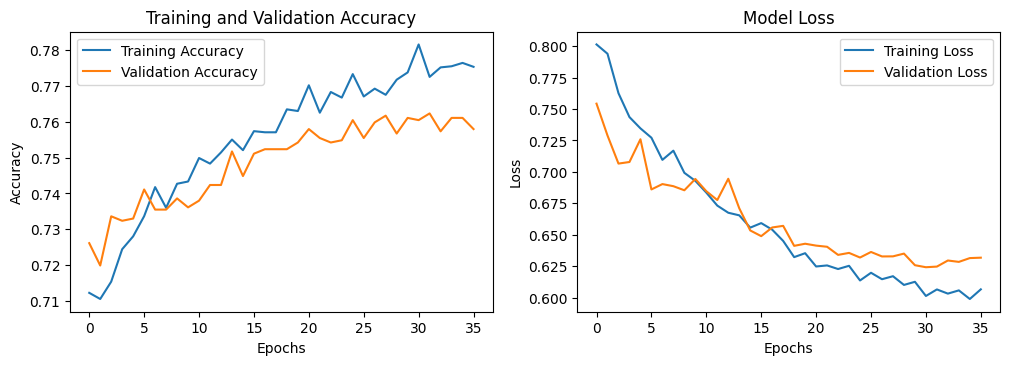

In [ ]:
plt.figure(figsize=(12, 8))

# training and validation accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# training and validation loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('Accuracy_loss_augmentedDropLearn.png', dpi = 300)

51/51 [==============================] - 1s 8ms/step


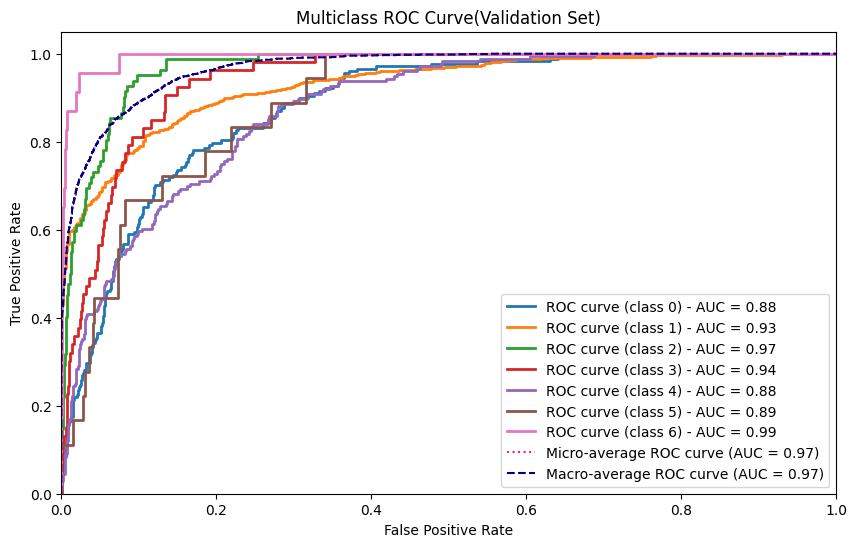

In [ ]:
y_val_pred = model.predict(X_val)
n_classes = len(np.unique(class_labels))  # Number of classes

# ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
roc_auc_macro = 0

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auc_macro += roc_auc[i]

# micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_val_pred.ravel())
roc_auc_micro = auc(fpr["micro"], tpr["micro"])

#  macro-average ROC AUC
roc_auc_macro /= n_classes

# ROC curves plot for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) - AUC = %0.2f' % (i, roc_auc[i]))

# micro-average plot ROC curve
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro, color='deeppink', linestyle=':')

# macro-average plot ROC curve
fpr_macro, tpr_macro, _ = roc_curve(y_val.ravel(), y_val_pred.ravel())
roc_auc_macro = auc(fpr_macro, tpr_macro)
plt.plot(fpr_macro, tpr_macro, label='Macro-average ROC curve (AUC = %0.2f)' % roc_auc_macro, color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve(Validation Set)')
plt.legend(loc='lower right')
plt.savefig('MultiRocValAugmDropLearn.png', dpi = 300)
plt.show()


63/63 [==============================] - 1s 8ms/step


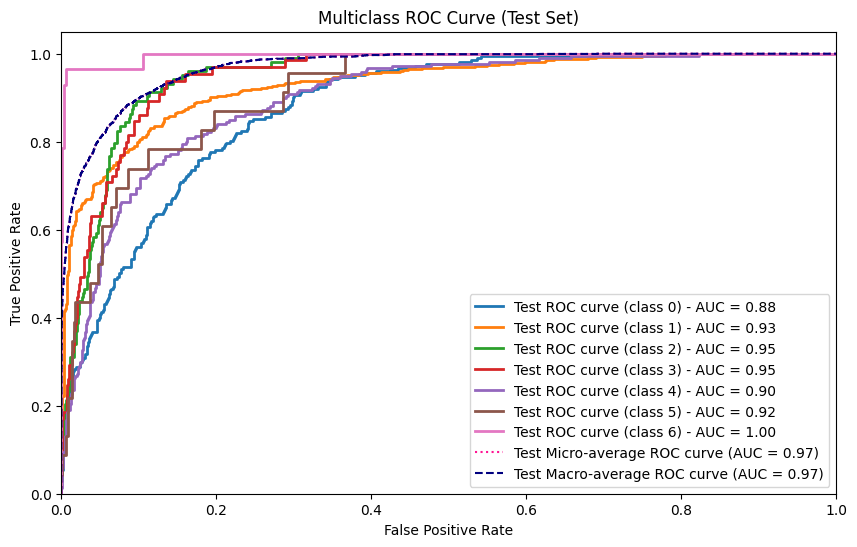

In [ ]:
# predictions on the test set
y_test_pred = model.predict(X_test)

n_classes = len(np.unique(class_labels))  # Number of classes

# ROC curve and ROC AUC for each class in the test set
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
roc_auc_macro_test = 0

for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    roc_auc_macro_test += roc_auc_test[i]

# micro-average ROC curve and ROC AUC for the test set
fpr_test["micro"], tpr_test["micro"], _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc_micro_test = auc(fpr_test["micro"], tpr_test["micro"])

# macro-average ROC AUC for the test set
fpr_macro_test, tpr_macro_test, _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc_macro_test = auc(fpr_macro_test, tpr_macro_test)

# ROC curves plot for each class in the test set
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_test[i], tpr_test[i], lw=2, label='Test ROC curve (class %d) - AUC = %0.2f' % (i, roc_auc_test[i]))

# micro-average ROC curve plot for the test set
plt.plot(fpr_test["micro"], tpr_test["micro"], label='Test Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro_test, color='deeppink', linestyle=':')

# macro-average ROC curve plot for the test set
plt.plot(fpr_macro_test, tpr_macro_test, label='Test Macro-average ROC curve (AUC = %0.2f)' % roc_auc_macro_test, color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.savefig('MultiRocTestAugmDropLearn.png', dpi = 300)
plt.show()


63/63 [==============================] - 1s 10ms/step


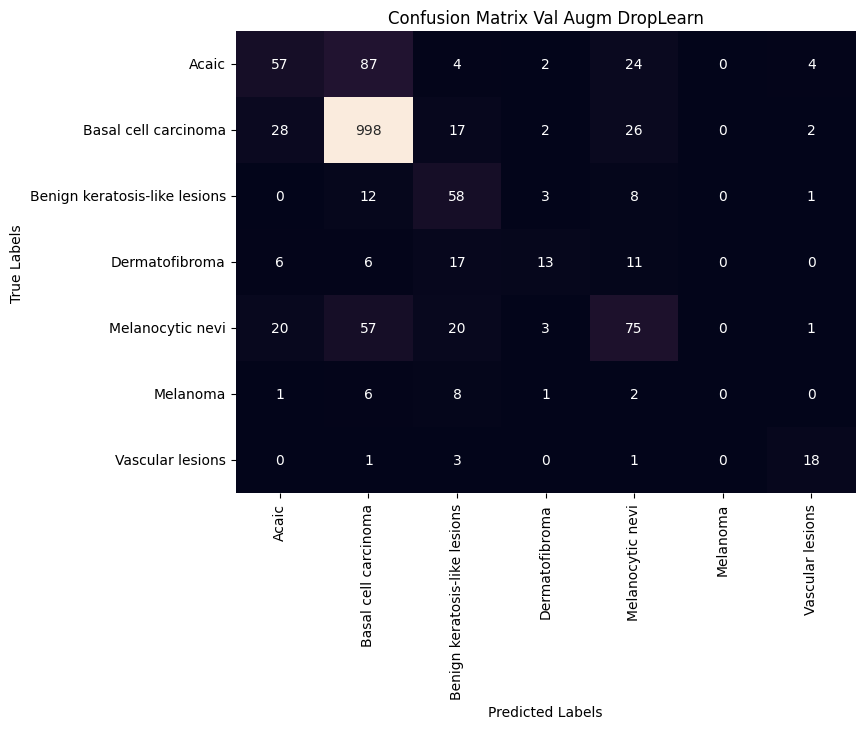

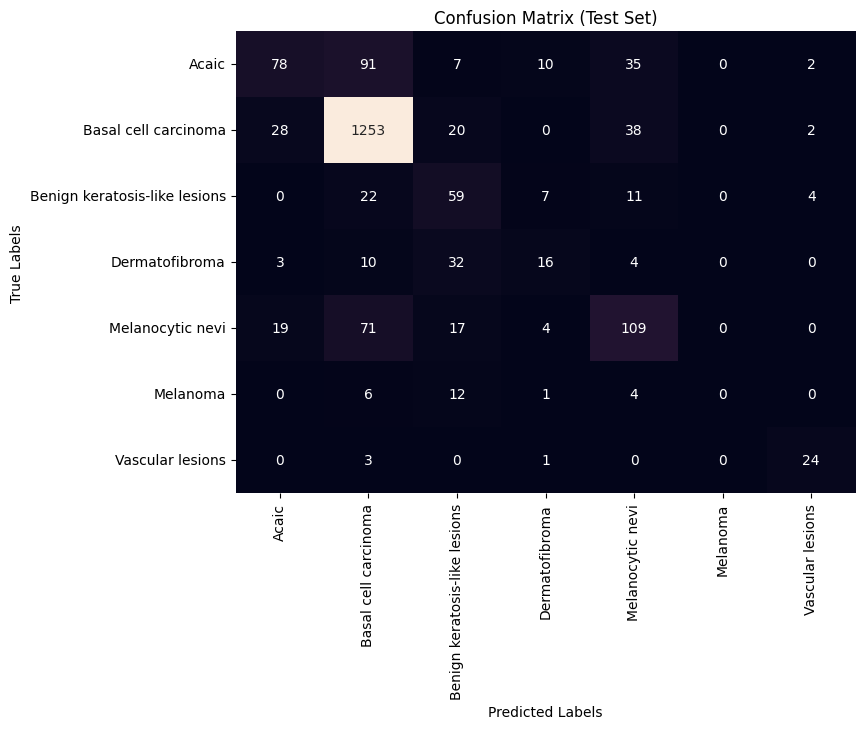

In [ ]:
# Predicting classes for the validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculating the true labels for the validation and test sets
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# confusion matrices
cm_val = confusion_matrix(y_val_true, np.argmax(y_val_pred, axis=1))
cm_test = confusion_matrix(y_test_true, np.argmax(y_test_pred, axis=1))

labels = np.unique(class_labels)
rocket_cmap = sns.color_palette("rocket", as_cmap=True)
# confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap=rocket_cmap, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Val Augm DropLearn")
plt.show()

# confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=rocket_cmap, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Set)")
plt.savefig('Confusion Matrix Test Augm DropLearn.png', dpi = 300)
plt.show()


## Dropout,l2 regularization,learning rate

In [ ]:
model = models.Sequential()

l2_strength = 0.002
# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 120, 3), padding='same',kernel_regularizer=regularizers.l2(l2_strength)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten before dense layers
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.7, seed=42))
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(7, activation='softmax'))

custom_optimizer = optimizers.Adam(learning_rate=0.001)

lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)

model.compile(optimizer=custom_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

# validation set predictions
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the validation set
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
val_classification_rep = classification_report(y_val_true_labels, y_val_pred_labels, zero_division=0)

# test set predictions
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the test set
test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
test_classification_rep = classification_report(y_test_true_labels, y_test_pred_labels, zero_division=0)

print("Validation Set:")
print(f'Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(val_classification_rep)

print("\nTest Set:")
print(f'Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(test_classification_rep)

Epoch 1/40
201/201 [==============================] - 10s 33ms/step - loss: 1.0899 - accuracy: 0.6653 - val_loss: 0.9806 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 2/40
201/201 [==============================] - 5s 27ms/step - loss: 0.9764 - accuracy: 0.6687 - val_loss: 0.9160 - val_accuracy: 0.6687 - lr: 9.0000e-04
Epoch 3/40
201/201 [==============================] - 6s 29ms/step - loss: 0.9111 - accuracy: 0.6708 - val_loss: 0.8891 - val_accuracy: 0.6856 - lr: 8.1000e-04
Epoch 4/40
201/201 [==============================] - 5s 26ms/step - loss: 0.8783 - accuracy: 0.6787 - val_loss: 0.8525 - val_accuracy: 0.6831 - lr: 7.2900e-04
Epoch 5/40
201/201 [==============================] - 6s 28ms/step - loss: 0.8551 - accuracy: 0.6878 - val_loss: 0.7922 - val_accuracy: 0.7068 - lr: 6.5610e-04
Epoch 6/40
201/201 [==============================] - 6s 28ms/step - loss: 0.8159 - accuracy: 0.6918 - val_loss: 0.8714 - val_accuracy: 0.6981 - lr: 5.9049e-04
Epoch 7/40
201/201 [=======================

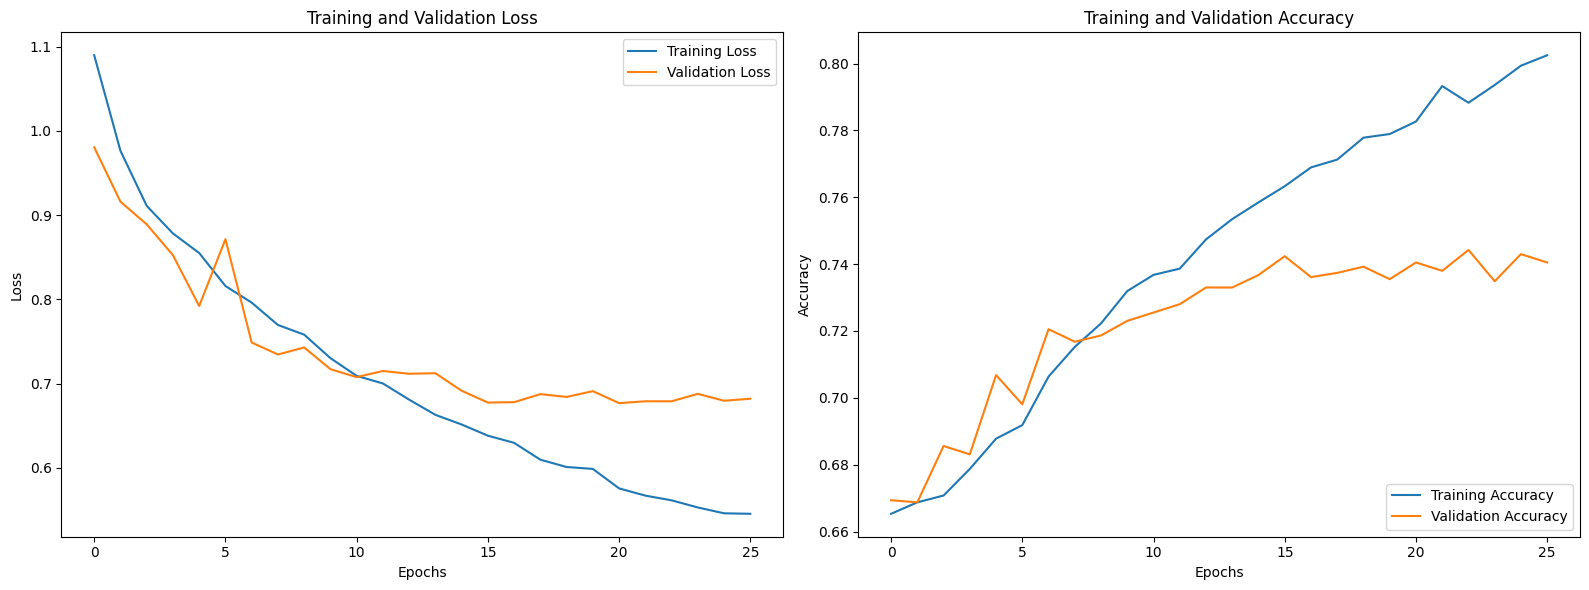

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

# training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='lower right')

plt.tight_layout()

plt.savefig('ModelLossAccuracyEnchancedDropoutl2learningrate.png',dpi=300)

plt.show()


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

# validation set predictions
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the validation set
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
val_classification_rep = classification_report(y_val_true_labels, y_val_pred_labels, zero_division=0)

# test set predictions
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the test set
test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
test_classification_rep = classification_report(y_test_true_labels, y_test_pred_labels, zero_division=0)

print("Validation Set:")
print(f'Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(val_classification_rep)

print("\nTest Set:")
print(f'Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(test_classification_rep)

Epoch 1/100
200/200 [==============================] - 59s 292ms/step - loss: 0.8259 - accuracy: 0.7057 - val_loss: 0.7978 - val_accuracy: 0.6993 - lr: 0.0010
Epoch 2/100
200/200 [==============================] - 36s 178ms/step - loss: 0.7916 - accuracy: 0.7162 - val_loss: 0.7339 - val_accuracy: 0.7193 - lr: 9.0000e-04
Epoch 3/100
200/200 [==============================] - 36s 181ms/step - loss: 0.7950 - accuracy: 0.7137 - val_loss: 0.7391 - val_accuracy: 0.7205 - lr: 8.1000e-04
Epoch 4/100
200/200 [==============================] - 36s 180ms/step - loss: 0.7623 - accuracy: 0.7190 - val_loss: 0.7210 - val_accuracy: 0.7230 - lr: 7.2900e-04
Epoch 5/100
200/200 [==============================] - 36s 180ms/step - loss: 0.7490 - accuracy: 0.7234 - val_loss: 0.7189 - val_accuracy: 0.7280 - lr: 6.5610e-04
Epoch 6/100
200/200 [==============================] - 34s 170ms/step - loss: 0.7476 - accuracy: 0.7248 - val_loss: 0.7107 - val_accuracy: 0.7305 - lr: 5.9049e-04
Epoch 7/100
200/200 [=====

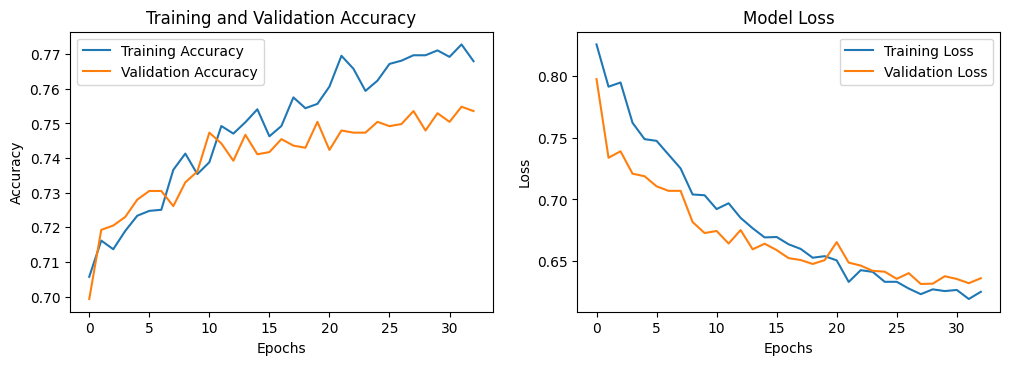

In [ ]:
plt.figure(figsize=(12, 8))

# training and validation accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# training and validation loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('Accuracy_loss_augmentedDropLearnL2.png', dpi = 300)

51/51 [==============================] - 1s 10ms/step


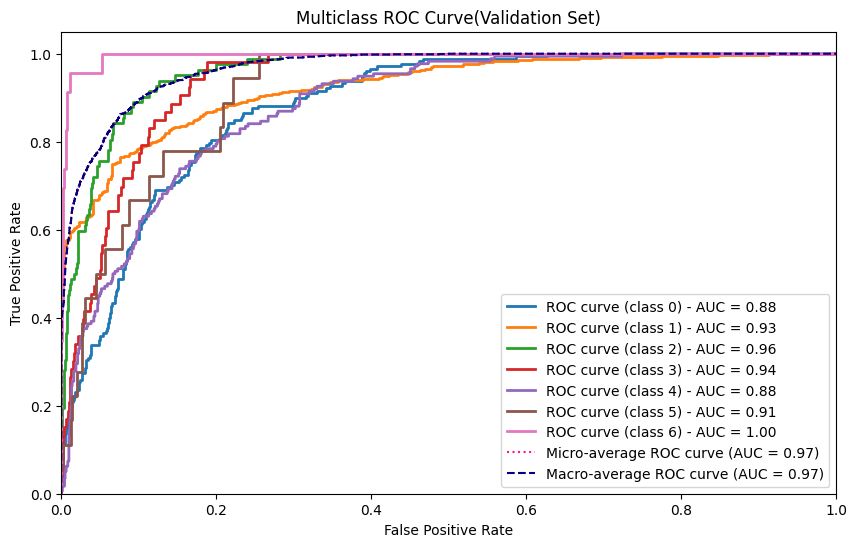

In [ ]:
y_val_pred = model.predict(X_val)
n_classes = len(np.unique(class_labels))  # Number of classes

# ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
roc_auc_macro = 0

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auc_macro += roc_auc[i]

# micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_val_pred.ravel())
roc_auc_micro = auc(fpr["micro"], tpr["micro"])

#  macro-average ROC AUC
roc_auc_macro /= n_classes

# ROC curves plot for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) - AUC = %0.2f' % (i, roc_auc[i]))

# micro-average plot ROC curve
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro, color='deeppink', linestyle=':')

# macro-average plot ROC curve
fpr_macro, tpr_macro, _ = roc_curve(y_val.ravel(), y_val_pred.ravel())
roc_auc_macro = auc(fpr_macro, tpr_macro)
plt.plot(fpr_macro, tpr_macro, label='Macro-average ROC curve (AUC = %0.2f)' % roc_auc_macro, color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve(Validation Set)')
plt.legend(loc='lower right')
plt.savefig('MultiRocValAugmDropLearnL2.png', dpi = 300)
plt.show()


63/63 [==============================] - 1s 8ms/step


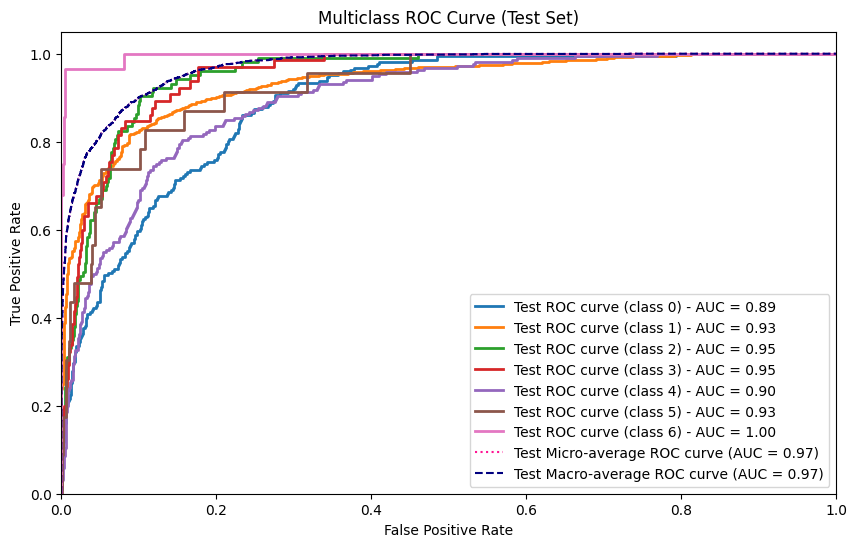

In [ ]:
# predictions on the test set
y_test_pred = model.predict(X_test)

n_classes = len(np.unique(class_labels))  # Number of classes

# ROC curve and ROC AUC for each class in the test set
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
roc_auc_macro_test = 0

for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    roc_auc_macro_test += roc_auc_test[i]

# micro-average ROC curve and ROC AUC for the test set
fpr_test["micro"], tpr_test["micro"], _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc_micro_test = auc(fpr_test["micro"], tpr_test["micro"])

# macro-average ROC AUC for the test set
fpr_macro_test, tpr_macro_test, _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc_macro_test = auc(fpr_macro_test, tpr_macro_test)

# ROC curves plot for each class in the test set
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_test[i], tpr_test[i], lw=2, label='Test ROC curve (class %d) - AUC = %0.2f' % (i, roc_auc_test[i]))

# micro-average ROC curve plot for the test set
plt.plot(fpr_test["micro"], tpr_test["micro"], label='Test Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro_test, color='deeppink', linestyle=':')

# macro-average ROC curve plot for the test set
plt.plot(fpr_macro_test, tpr_macro_test, label='Test Macro-average ROC curve (AUC = %0.2f)' % roc_auc_macro_test, color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.savefig('MultiRocTestAugmDropLearnL2.png', dpi = 300)
plt.show()


63/63 [==============================] - 1s 8ms/step


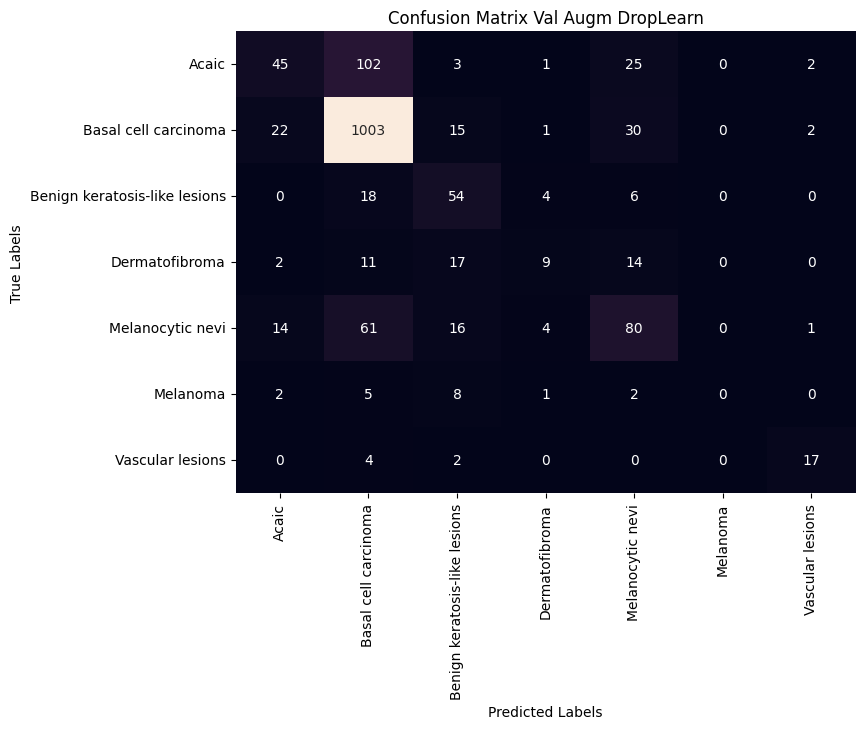

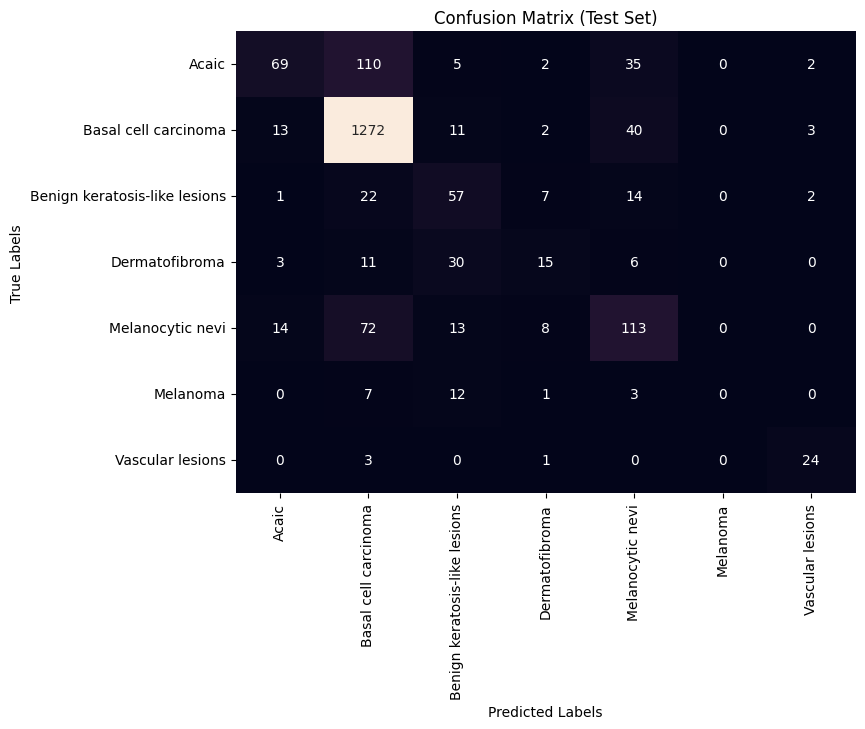

In [ ]:
# Predicting classes for the validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculating the true labels for the validation and test sets
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# confusion matrices
cm_val = confusion_matrix(y_val_true, np.argmax(y_val_pred, axis=1))
cm_test = confusion_matrix(y_test_true, np.argmax(y_test_pred, axis=1))

labels = np.unique(class_labels)
rocket_cmap = sns.color_palette("rocket", as_cmap=True)
# confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap=rocket_cmap, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Val Augm DropLearn")
plt.show()

# confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=rocket_cmap, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Set)")
plt.savefig('Confusion Matrix Test Augm DropLearnL2.png', dpi = 300)
plt.show()


## Transfer Learning Model

In [ ]:
from tensorflow.keras.applications import Xception
# Loading pre-trained ResNet50 model without the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 120, 3))

# Adding custom fully connected layers on top of ResNet50 to create a model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

custom_optimizer = optimizers.Adam(learning_rate=0.001)

lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)

model.compile(optimizer=custom_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

# Evaluate on the test set
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# validation set predictions
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the validation set
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
val_classification_rep = classification_report(y_val_true_labels, y_val_pred_labels, zero_division=0)

# test set predictions
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# accuracy, sensitivity, specificity, and F1-score for the test set
test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
test_classification_rep = classification_report(y_test_true_labels, y_test_pred_labels, zero_division=0)

print("Validation Set:")
print(f'Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(val_classification_rep)

print("\nTest Set:")
print(f'Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(test_classification_rep)

Epoch 1/40
201/201 [==============================] - 89s 240ms/step - loss: 0.9559 - accuracy: 0.6848 - val_loss: 1.7145 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 2/40
201/201 [==============================] - 44s 219ms/step - loss: 0.7333 - accuracy: 0.7366 - val_loss: 0.8197 - val_accuracy: 0.6581 - lr: 9.0000e-04
Epoch 3/40
201/201 [==============================] - 44s 217ms/step - loss: 0.6019 - accuracy: 0.7923 - val_loss: 0.9391 - val_accuracy: 0.7236 - lr: 8.1000e-04
Epoch 4/40
201/201 [==============================] - 44s 218ms/step - loss: 0.5191 - accuracy: 0.8251 - val_loss: 0.8000 - val_accuracy: 0.7586 - lr: 7.2900e-04
Epoch 5/40
201/201 [==============================] - 44s 217ms/step - loss: 0.4110 - accuracy: 0.8666 - val_loss: 0.8052 - val_accuracy: 0.7243 - lr: 6.5610e-04
Epoch 6/40
201/201 [==============================] - 44s 219ms/step - loss: 0.3141 - accuracy: 0.8978 - val_loss: 0.7301 - val_accuracy: 0.7692 - lr: 5.9049e-04
Epoch 7/40
201/201 [============

63/63 [==============================] - 3s 50ms/step


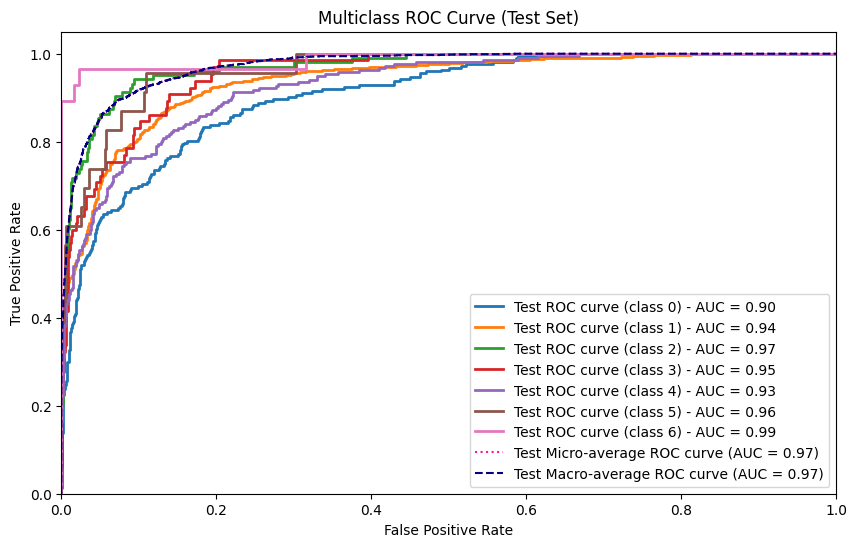

In [ ]:
# predictions on the test set
y_test_pred = model.predict(X_test)

n_classes = len(np.unique(class_labels))

# ROC curve and ROC AUC for each class in the test set
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
roc_auc_macro_test = 0

for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    roc_auc_macro_test += roc_auc_test[i]

# micro-average ROC curve and ROC AUC for the test set
fpr_test["micro"], tpr_test["micro"], _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc_micro_test = auc(fpr_test["micro"], tpr_test["micro"])

# macro-average ROC AUC for the test set
fpr_macro_test, tpr_macro_test, _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc_macro_test = auc(fpr_macro_test, tpr_macro_test)

# ROC curves plot for each class in the test set
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_test[i], tpr_test[i], lw=2, label='Test ROC curve (class %d) - AUC = %0.2f' % (i, roc_auc_test[i]))

# micro-average ROC curve plot for the test set
plt.plot(fpr_test["micro"], tpr_test["micro"], label='Test Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro_test, color='deeppink', linestyle=':')

# macro-average ROC curve plot for the test set
plt.plot(fpr_macro_test, tpr_macro_test, label='Test Macro-average ROC curve (AUC = %0.2f)' % roc_auc_macro_test, color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.savefig('MultiRocTestTransfer.png', dpi = 300)
plt.show()

63/63 [==============================] - 3s 50ms/step


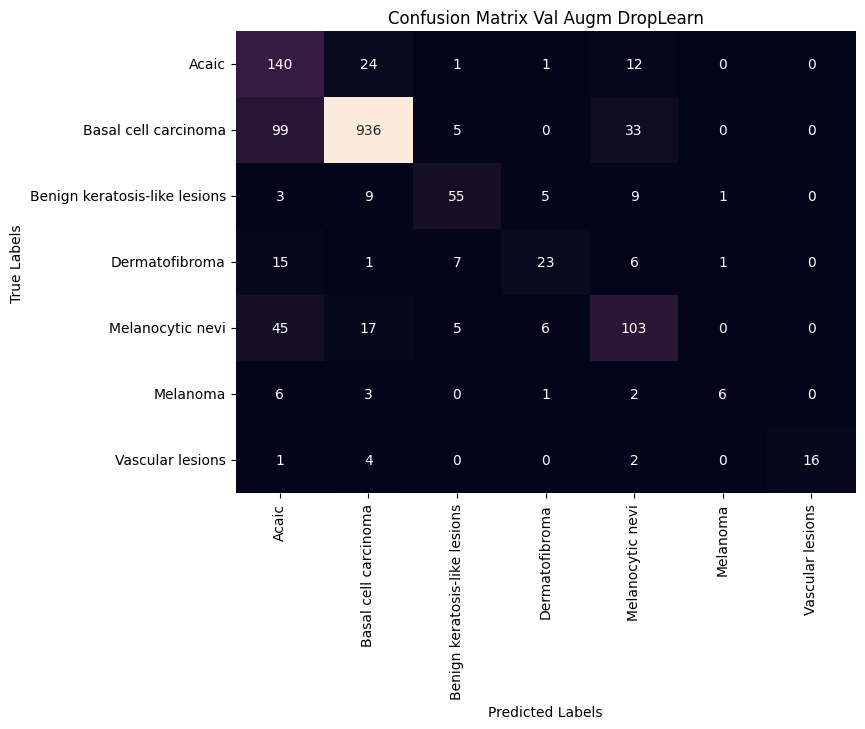

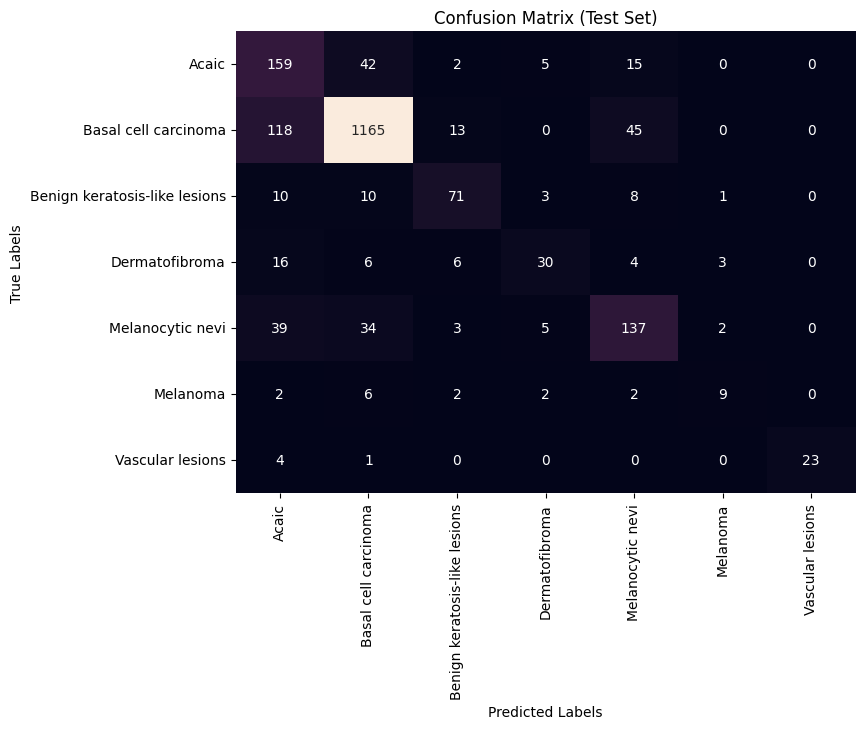

In [ ]:
# Predicting classes for the validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculating the true labels for the validation and test sets
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# confusion matrices
cm_val = confusion_matrix(y_val_true, np.argmax(y_val_pred, axis=1))
cm_test = confusion_matrix(y_test_true, np.argmax(y_test_pred, axis=1))

labels = np.unique(class_labels)
rocket_cmap = sns.color_palette("rocket", as_cmap=True)
# confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap=rocket_cmap, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Transfer Learning")
plt.show()

# confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=rocket_cmap, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Set)")
plt.savefig('Confusion Matrix Test Transfer Learning.png', dpi = 300)
plt.show()
